Part 2: Predicting precision: straight sum, linearly trained, specifically trained.

Setup:

In [16]:
%matplotlib inline
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from scipy.stats import poisson
import matplotlib.patches as mpatches
from functools import partial
import os
import pickle
import demixing as dm
from demixing import MLP, HiddenLayer

nneuron = 61
min_angle = -90
max_angle = 90
sprefs = np.linspace(min_angle, max_angle, nneuron)
eps = np.finfo(np.float64).eps
sigtc_sq = float(10**2)

Train network:

In [2]:
nns = {}
for i in range(400):
    file_name = 'output_nn_tests_2/nn_tests_2_' + str(i) + '.pkl'
    if os.path.isfile(file_name):
        pkl_file = open(file_name, 'rb')
        nn, nnx, valid_mse, _, _ = pickle.load(pkl_file)
        nns[i] = (nn, nnx, valid_mse)

In [180]:
posts = {}
testsets = {}
for s_i in range(31):
    file_name = 'output_post_2/post_2_' + str(s_i) + '.pkl'
    if os.path.isfile(file_name):
        pkl_file = open(file_name, 'rb')
        p, r, c, delta_s = pickle.load(pkl_file)
        posts[delta_s] = p
        testsets[delta_s] = r

In [117]:
pkl_file = open('readout.pkl', 'wb')
pickle.dump((posts, testsets), pkl_file)
pkl_file.close()

In [190]:
posts = {}
testsets = {}
for s_i in range(91):
    file_name = 'output_post/post_' + str(s_i) + '.pkl'
    if os.path.isfile(file_name):
        pkl_file = open(file_name, 'rb')
        p, r, c, delta_s = pickle.load(pkl_file)
        posts[c, delta_s] = p
        testsets[c, delta_s] = r

In [191]:
#pkl_file = open('output_nn_tests_3/nn_tests_3_26.pkl', 'rb')
#pkl_file = open('output_nn_tests_2/nn_tests_2_43.pkl', 'rb')
pkl_file = open('output_nn_runs/nn_runs212.pkl', 'rb')
nn, nnx, valid_mse, _, _ = pickle.load(pkl_file)

Readout of posterior:

In [ ]:
#nn, nnx, valid_mse = nns[43]
#print nn, nnx, valid_mse
x = []
y = []
for s_i in range(31):
    x.append(dm.get_hu_responses(testsets[s_i], nn))
    y.append(np.array((1/posts[s_i]['var_s1'], 1/posts[s_i]['var_s2'])))
y = np.concatenate(y, axis=1).T
x = np.concatenate(x)
inds = range(len(x))
np.random.shuffle(inds)
x_shuf = x[inds]
y_shuf = y[inds]
validset = x_shuf[0:2000], y_shuf[0:2000]
trainset = x_shuf[2000:], y_shuf[2000:]

In [199]:
x = []
y = []
for s_i in range(30):
    x.append(dm.get_hu_responses(testsets[4, s_i], nn))
    y.append(np.array((1/posts[4, s_i]['var_s1'], 1/posts[4, s_i]['var_s2'])))
y = np.concatenate(y, axis=1).T
x = np.concatenate(x)
inds = range(len(x))
np.random.shuffle(inds)
x_shuf = x[inds]
y_shuf = y[inds]
validset = x_shuf[0:2000], y_shuf[0:2000]
trainset = x_shuf[2000:], y_shuf[2000:]

In [200]:
nn_post, nnx_post, valid_mse_post = dm.train_nn(trainset, valid_dataset=validset, n_in=20, learning_rate=0.00005, n_epochs=100, linear=True, rho=.9, mu=.99, nesterov=True)

In [201]:
valid_mse_post

array([ 0.00922597,  0.00490709,  0.00387607,  0.00332281,  0.00301643,
        0.00283174,  0.00270614,  0.00261166,  0.00253585,  0.00247263,
        0.00241879,  0.00237227,  0.00233168,  0.00229597,  0.00226435,
        0.00223618,  0.00221095,  0.00218823,  0.00216769,  0.00214903,
        0.00213202,  0.00211645,  0.00210216,  0.002089  ,  0.00207686,
        0.00206562,  0.0020552 ,  0.00204553,  0.00203652,  0.00202813,
        0.0020203 ,  0.00201298,  0.00200612,  0.00199971,  0.0019937 ,
        0.00198807,  0.00198278,  0.00197782,  0.00197315,  0.00196876,
        0.00196463,  0.00196073,  0.00195706,  0.0019536 ,  0.00195034,
        0.00194725,  0.00194434,  0.00194158,  0.00193897,  0.0019365 ,
        0.00193416,  0.00193194,  0.00192983,  0.00192783,  0.00192593,
        0.00192412,  0.0019224 ,  0.00192076,  0.00191919,  0.0019177 ,
        0.00191628,  0.00191492,  0.00191362,  0.00191238,  0.00191119,
        0.00191005,  0.00190896,  0.00190791,  0.0019069 ,  0.00

[[ 1.         0.7483203]
 [ 0.7483203  1.       ]]


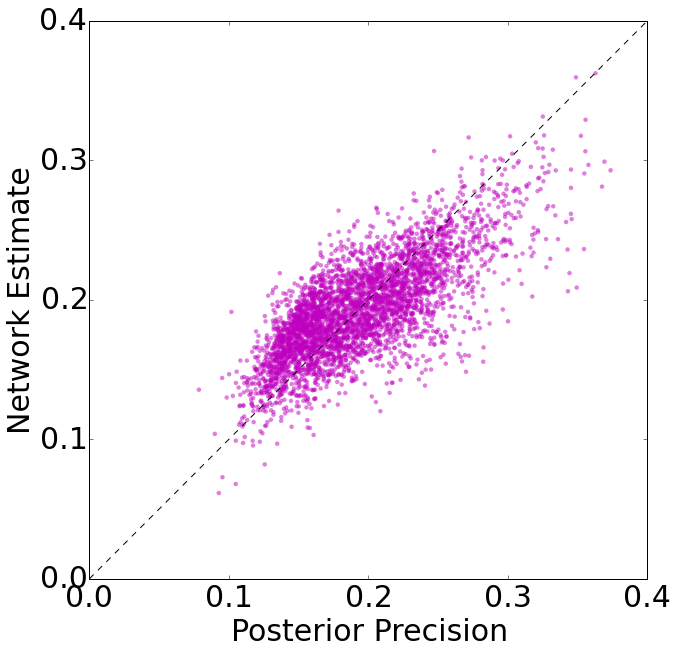

In [202]:
plt.rc('font', size=30)
hus, vpost = validset
nn_posts1 = dm.get_hu_responses(hus, nn_post)
vp = np.concatenate((vpost.T[0], vpost.T[1]))
np1 = np.concatenate((nn_posts1.T[0], nn_posts1.T[1]))
plt.figure(figsize=(10,10))
plt.scatter(vp, np1, c='m', alpha=.5, edgecolor="None")
plt.xlim(0, 0.4)
plt.ylim(0, 0.4)
plt.xlabel("Posterior Precision")
plt.ylabel("Network Estimate")
plt.locator_params(nbins=5)
plt.plot(range(2), '--', c='k')
print np.corrcoef(vp, np1)

[[ 1.          0.48219284]
 [ 0.48219284  1.        ]]


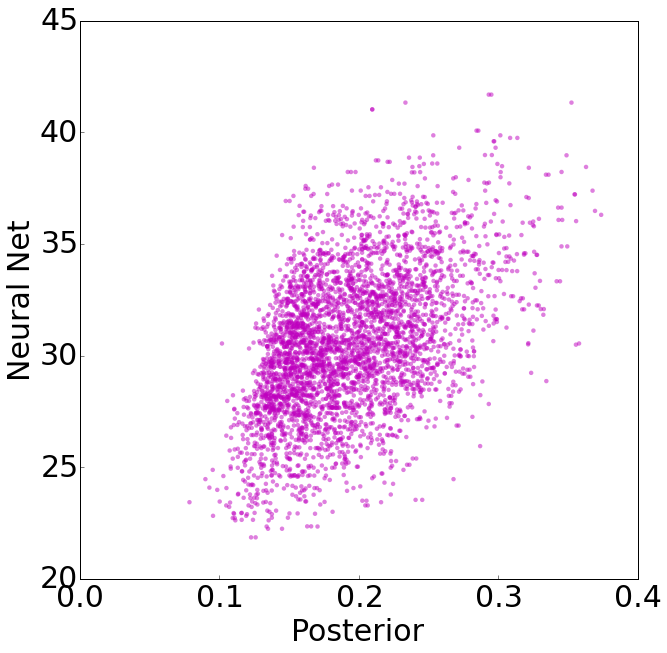

In [203]:
hus, vpost = validset
nn_posts1 = np.sum(hus, axis=1)
vp = np.concatenate((vpost.T[0], vpost.T[1]))
np1 = np.concatenate((nn_posts1, nn_posts1))
plt.figure(figsize=(10,10))
plt.scatter(vp, np1, c='m', alpha=.5, edgecolor="None")
#plt.scatter(vp[1], nn_posts1)
plt.xlim(0, .4)
plt.xlabel("Posterior")
plt.ylabel("Neural Net")
ax = plt.axes()
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.locator_params(nbins=5)
print np.corrcoef(vp, np1)

In [ ]:
x = []
y = []
for s_i in range(31):
    x.append(testsets[s_i])
    y.append(np.array((1/posts[s_i]['var_s1'], 1/posts[s_i]['var_s2'])))
y = np.concatenate(y, axis=1).T
x = np.concatenate(x)
x_shuf = x[inds]
validset2 = x_shuf[0:2000], y_shuf[0:2000]
trainset2 = x_shuf[2000:], y_shuf[2000:]

In [209]:
x = []
y = []
for s_i in range(30):
    x.append(testsets[4, s_i])
    y.append(np.array((1/posts[4, s_i]['var_s1'], 1/posts[4, s_i]['var_s2'])))
y = np.concatenate(y, axis=1).T
x = np.concatenate(x)
x_shuf = x[inds]
validset2 = x_shuf[0:2000], y_shuf[0:2000]
trainset2 = x_shuf[2000:], y_shuf[2000:]

In [210]:
nn_post2, nnx_post2, valid_mse_post2 = dm.train_nn(trainset2, valid_dataset=validset2, learning_rate=0.0001, mult_ys=False, n_epochs=100, rho=.9, mu=.99, nesterov=True)

[[ 1.          0.95420713]
 [ 0.95420713  1.        ]]


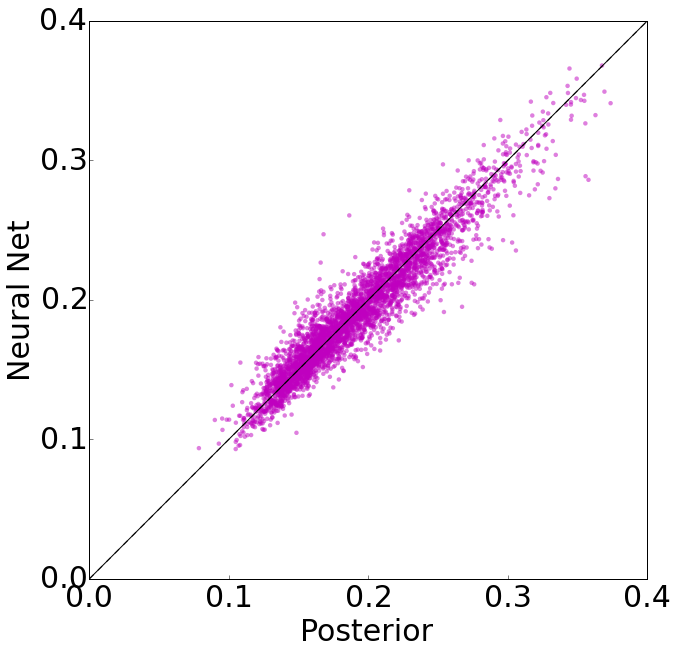

In [211]:
_, vpost2 = validset2
nn_posts2, _ = dm.test_nn(nn_post2, nnx_post2, validset2)
vp = np.concatenate((vpost2.T[0], vpost2.T[1]))
np2 = np.concatenate((nn_posts2.T[0], nn_posts2.T[1]))
plt.figure(figsize=(10,10))
plt.scatter(vp, np2, c='m', alpha=.5, edgecolor="None")
plt.xlim(0, 1)
plt.xlabel("Posterior")
plt.ylabel("Neural Net")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(range(2), c='k')
ax = plt.axes()
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.locator_params(nbins=5)
plt.xlim(0, 0.4)
plt.ylim(0, 0.4)
plt.plot(range(2), '--', c='k')
print np.corrcoef(vp, np2)